# Loading in the data and some model musings

Let's first load in the data and then get the basic matching nets architecture up and going.  One thing that seems like it could be fun to play with here is adding a siamese kind of constraint to the model on the batch.

So when we generate a batch, make sure that we have some same and different images for the test images (balanced).  With the loss for matching nets, we have already placed a loss that passes gradients up to the parameters of the encoder.  But the encoder could also be viewed as part of a larger siamese network and we could add the binary siamese loss to the batch loss as well.  

Would this kind of blending of models be useful?  Provide a performance enhancement?

On some level, it would at least seem to regularize by demanding the model be proficient at (or adapt to) different tasks.  It would also seem to "expand" the dataset a little bit by augmenting the comparisons we make.  Together with traditional data augmentation, how well would this kind of approach work? 

Let's load in the data

In [1]:
import numpy as np
import pandas as pd

# Set seed
np.random.seed(0)

# Load the background dataset. X_background contains the background
# images and y_background class information.
train_npz_file = np.load('../data/processed/train_28.npz')
X_background, y_background = train_npz_file['arr_0'], train_npz_file['arr_1']

# Load the evaluation dataset. X_evaluation contains the background
# images and y_evaluation class information.
test_npz_file = np.load('../data/processed/test_28.npz')
X_evaluation, y_evaluation = test_npz_file['arr_0'], test_npz_file['arr_1']

# Put the class information in pandas arrays for ease of exploration
# and constrained sampling.  
y_background_pd = pd.DataFrame(
                    data=y_background, 
                    columns=['Alphabet', 'Character', 'Drawer']
    )
y_evaluation_pd = pd.DataFrame(
                    data=y_evaluation, 
                    columns=['Alphabet', 'Character', 'Drawer']
    )

# Check shapes of images.
print(X_background.shape, y_background.shape, X_evaluation.shape, y_evaluation.shape)

(19280, 28, 28) (19280, 3) (13180, 28, 28) (13180, 3)


First we want to reshape the image arrays so that they fit with what pytorch is expecting for convolutional layers.

In [9]:
X_background = X_background.reshape(X_background.shape[0], 1, 28, 28)
X_evaluation = X_evaluation.reshape(X_evaluation.shape[0], 1, 28, 28)

And split the background set randomly into training and testing sets.

In [10]:
# Further split the background set into training and validation sets
# by reserving a fraction of the 20 drawers for validation:
# --> first isolate the unique drawers (there are 20 of these)
# --> randomly select 16 of these to send to training set and the remaining 4 to validation 
drawers = y_background_pd.Drawer.unique()
trn_drawers = np.random.choice(drawers, 16, replace=False)
trn_inds = y_background_pd.Drawer.isin(trn_drawers)
X_trn, y_trn = X_background[trn_inds], y_background[trn_inds]
X_val, y_val = X_background[~trn_inds], y_background[~trn_inds]

Load in some custom utilities and create one-shot data loaders for each of the training, validation and testing datasets.

In [11]:
import os
import sys
new_path = os.getcwd() + '/../src'
if new_path not in sys.path:
    sys.path.append(new_path)

%load_ext autoreload
%autoreload 2

from data.data_utils import OneShotGenerator
from data.data_utils import plot_oneshot_task

TstData = OneShotGenerator(X_evaluation, y_evaluation)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now try generating and plotting a one-shot task

In [12]:
x_pairs, y_pairs = TrnData.generate_one_shot()

print('Below is a one-shot sample of characters from the {} alphabet.'.format(
                        y_pairs[0].Alphabet.iloc[0]) + \
      ' The sampled characters are at the same positions in both test and support plots.\n')
pairs = [x_pairs[0].reshape(20, 105, 105, 1), x_pairs[1].reshape(20, 105, 105, 1)]
# Note, the plot may fail sometimes since the training data has alphabets with less than
# 20 characters.  In this case, the OneShotGenerator samples test and support examples of
# the entire alphabet (from two randomly selected drawers).  The plot_oneshot (which was
# disigned to plot 20-way tasks) fails in this case.  Re-running the cell should generate
# a new sample that works.
plot_oneshot_task(pairs)

Below is a one-shot sample of characters from the Balinese alphabet. The sampled characters are at the same positions in both test and support plots.



ValueError: cannot reshape array of size 15680 into shape (20,105,105,1)

# Generating flexible matching networks

We want to be able to specify encoder parameters and output/train a matching network.   Maybe sync this up with bayesian optimization so that we can scan over a few different architectures and parameter choices and find something that works well on the data.  

Maybe the best place to start is to try to reproduce the architecture from the original paper and see if we can get matching networks matching their results.  Then see if we can improve on this with parameter tuning and maybe a synthesis of methods.

One thing we may want to do here is reload and store the data in 28 * 28 format, as this is what's done in the matching nets paper.  So just adjust that script.

In [4]:
from skimage.transform import resize
import matplotlib.pyplot as plt

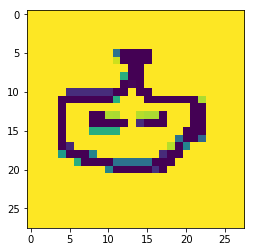

In [13]:
plt.imshow(X_trn[0, 0, :, :])

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [124]:
from data.data_utils import BatchingForMatching

batch_size, im_dim, n_channels, n_way = 128, 28, 1, 20
TrnData = BatchingForMatching(X_trn, y_trn, cache_size=48, batch_size=batch_size)
ValData = BatchingForMatching(X_val, y_val, cache_size=48, batch_size=batch_size)

In [125]:
loss = torch.nn.CrossEntropyLoss()
cos = nn.CosineSimilarity(dim=2)
softmax = torch.nn.Softmax(dim=1)

In [126]:
def convLayer(in_planes, out_planes, useDropout = False):
    "3x3 convolution with padding"
    seq = nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=3,
                  stride=1, padding=1, bias=True),
        nn.BatchNorm2d(out_planes),
        nn.ReLU(True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    if useDropout: # Add dropout module
        list_seq = list(seq.modules())[1:]
        list_seq.append(nn.Dropout(0.1))
        seq = nn.Sequential(*list_seq)

    return seq

In [102]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
      
encoder = torch.nn.Sequential(
                torch.nn.Conv2d(
                    in_channels=1, 
                    out_channels=64,
                    kernel_size=5
                ),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(2),
                torch.nn.Dropout2d(),
                torch.nn.Conv2d(
                    in_channels=64, 
                    out_channels=128,
                    kernel_size=3
                ),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(2),
                torch.nn.Dropout2d(),
                Flatten(),
                torch.nn.Linear(73728, 128) #int(128 * 3 * 3 / 4), 128)
            )

In [111]:
import math
layer_size = 64
outsize = (int(math.floor(28 / (2 * 2 * 2 * 2))) ** 2) * layer_size
outsize

64

In [127]:
# This is the encoder used in the paper.
# Missed that output needs to be n_way,
# but don't think that this is the case.
encoder = torch.nn.Sequential(
                convLayer(1, 64),
                convLayer(64, 64),
                convLayer(64, 64),
                convLayer(64, 64),
                Flatten() #,
                # nn.Linear(64, n_way)
    )

In [128]:
optimizer = torch.optim.Adam(encoder.parameters(), lr=5e-4, weight_decay=1e-4)
encoder = encoder.to(device=device)

In [129]:
dtype = torch.float32

In [130]:
def check_accuracy(loader, model, n_evals=200):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        target_ims, target_classes, support_set_ims, support_set_classes = loader.generate_batch()
      
        # Push batch to device
        target_ims = target_ims.to(device=device, dtype=dtype)
        target_classes = target_classes.to(device=device, dtype=torch.long)
        support_set_ims = support_set_ims.to(device=device, dtype=dtype)
        support_set_classes = support_set_classes.to(device=device, dtype=dtype)
    
        # Push batch through the model
        target_embedding = model(target_ims)
        support_set_embeddings = torch.stack(
              [model(support_set_ims[:, i, :, :, :]) for i in range(n_way)]
            )

        similarities = cos(
                  target_embedding.repeat([n_way, 1, 1]), 
                  support_set_embeddings
              ).t()
        softmax = torch.nn.Softmax(dim=1)
        softmax_sims = softmax(similarities)
        preds = softmax_sims.unsqueeze(1).bmm(support_set_classes).squeeze()
        
        num_correct = 0
        for i in range(n_evals):
            num_correct += (torch.argmax(preds, dim=1) == target_classes).sum()
        acc = float(num_correct) / (batch_size * n_evals)
        print('Got %d / %d correct (%.2f)' % (num_correct, batch_size * n_evals , 100 * acc))

In [131]:
def get_preds(target_ims, support_set_ims, support_set_classes, model):
    # Calculate target and support set embeddings by model
    target_embedding = model(target_ims)
    support_set_embeddings = torch.stack(
        [model(support_set_ims[:, i, :, :, :]) for i in range(n_way)]
        )
    # calculate similarities, softmax_sims and output predictions
    similarities = cos(
            target_embedding.repeat([n_way, 1, 1]), 
            support_set_embeddings
        ).t()
    softmax_sims = softmax(similarities)
    return softmax_sims.unsqueeze(1).bmm(support_set_classes).squeeze()

In [140]:
running_loss = 0

for i in range(5000):
    encoder.train()
    # Pull batch from batch generator
    target_ims, target_classes, support_set_ims, support_set_classes = TrnData.generate_batch()
    # Push to device
    # Push batch to device
    target_ims = target_ims.to(device=device, dtype=dtype)
    target_classes = target_classes.to(device=device, dtype=torch.long)
    support_set_ims = support_set_ims.to(device=device, dtype=dtype)
    support_set_classes = support_set_classes.to(device=device, dtype=dtype)
    
    preds = get_preds(target_ims, support_set_ims, support_set_classes, encoder)
    lp = loss(preds, target_classes)
    optimizer.zero_grad()
    lp.backward()
    optimizer.step()
    
    running_loss += lp.item()
    if (i > 0) and (i % 50 == 0):
        print("After {} batches, the training performance is: ".format(i))
        check_accuracy(TrnData, encoder)
        print("And the validation performance is: ")
        check_accuracy(ValData, encoder)
        print("And the loss is: {}".format(running_loss / 50))
        running_loss = 0
        print("                                                    ")
        print("----------------------------------------------------")
        print("                                                    ")

After 50 batches, the training performance is: 
Got 16800 / 25600 correct (65.62)
And the validation performance is: 
Got 13000 / 25600 correct (50.78)
And the loss is: 3.025717740058899
                                                    
----------------------------------------------------
                                                    
After 100 batches, the training performance is: 
Got 10600 / 25600 correct (41.41)
And the validation performance is: 
Got 7200 / 25600 correct (28.12)
And the loss is: 2.9645908641815186
                                                    
----------------------------------------------------
                                                    
After 150 batches, the training performance is: 
Got 7200 / 25600 correct (28.12)
And the validation performance is: 
Got 14600 / 25600 correct (57.03)
And the loss is: 2.9602783632278444
                                                    
----------------------------------------------------
             

Seems quite finicky to train.  At `1e-5` was bouncing all over the place.  Found one of the implementations that was using learning rate at `1e-3` and weight decay at `1e-4` with Adam...  Hopefully this settles into some good weights without ping-ponging around as much.  With the large initial weights, fluctuations may be large at first but settle down?

They also used different batch sizes.  So maybe the thing to do here is pick ranges of:
    - learning rate decay
    - weight decay
    - batch size

And maybe a few other things.  Then do a Bayesian optimization over these things to try to find a good configuration. Might want to experiment with similar things with stochastic gradient descent.  

Other things to play with here are:
    - incorporating a siamese type structure across the batches. E.g. if we do small batches, like 32 we can do a siamese loss over all pairs.  Would this help any.
    - could also force the encoder to do other things, like serves as the front end of a decoder.
    
In both of these instances, we are adding additional losses to backprop derivatives from.  Would this be useful in the form of a sort of regularization.  I.e. providing accountability to more than one metric. 

Seemed to get similar problems with other  implementations.  Maybe the keys are 

Would be interesting to watch the errors unfold 


Another good thing to keep track of is the actual loss we are trying to minimize and what it is doing.  


One thought is that it may be ping-ponging around so much because we are sampling 20-shot tasks from the **entire** set of characters.  So some may be **much** more difficult than others.  And because of the caching, this comes in cycles??  Anyway, if this is the case, it's argument for letting the thing train for a long time.  At least until this phenomena stabilizes a bit.  Another thing is that the  tasks on training and validation may be quite a bit more difficult than we will see on testing... How will this affect things?

Based on this, may be worth seeing how the loss is doing (which more or less must be a direct reflection of accuracy on the training set/samples... So not sure why this is ping-ponging around so much) on one-shot tasks that reflect what we want to do.  I.e. generated from the validation set from the same alphabet.   

And how does learning do if we generate from the same alphabet... Did horribly with siamese nets.

Maybe we want to be looking at the actual task on validation data instead of a  mutated, more difficult version of it which may fluctuate super wildly as it seems to be doing.

On the one hand, might want to follow their actual method of batch sampling which more closely parallels what we did with the first iteration of siamese nets.  On the other hand, may be worth looking at how Val data is doing on actual one-shot tasks that we care about.  

The reference paper  is a bit vague on how to carry out what we're doing.  May want a bit more focus on the support set's in a class... This may be part of the problem.

